# JRC multilabel EN first test

Test of using **FastAI** with the **JRC Acquis dataset**.
This dataset is: **multilabel-label, multi-class, English language**.


What is done:

1.   Finetune a language model with the text in JRC
2.   Train a classifier with the encoder part of the trained language model and the classification dataset








In [2]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN='merged.csv'


bs = 32

## Fine-tuning of the language model

In [42]:

data_lm = (TextList.from_csv(Path('.'), FN, cols='text') #, max_vocab=60000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

print('done')

done


In [6]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

In [44]:
data_lm.show_batch()

idx,text
0,community procedure change substance instrument codification parliament council commission agreement date < date > procedure adoption codification instrument purpose proposal codification < legalact > < date > recognition navigability licence inland < legalact > act incorporate proposal content act hence bring amendment require codification exercise codification proposal basis consolidation official language < legalact > instrument office official publication community system number correlation number show contain codify < legalact > proposal
1,grant typeapproval measure accordance verify arrangement production vehicle system unit type whereas govern control conformity production carry approval authority harmonise order application interpretation guidance procedure whereas measure accordance opinion committee adaptation progress adopt < legalact > < reference><legalact > < reference > application vehicle manufacturer approval authority member state application information folder contain information approval certificate < legalact > require xi information package system unit approval respect < legalact >
2,< reference > romania austria agreement – < reference > romania belgium agreement – < reference > romania cyprus agreement – < reference > romania czech agreement – < reference > romania denmark agreement – < reference > romania finland agreement – < reference > romania france agreement – < reference > – agreement < reference > romania greece agreement – < reference > romania hungary – agreement < reference
3,date transaction ie < date > book value < date > base market value company amount base information aesa eur company eur – gain conclusion payment eur company cadiz juliana manis accordance market investor principle gain therefore consider state aid aesa sale shipyard company ship construction state aid commission market authorise restructuring aid type aid report company state continuation operation support shareholder ie sepi aesa information commission conclude aid transaction
4,"role promote right union help people exercise action commitment entity member state support society promote dialogue see fight discrimination peace way programme justice “ "" action fight racism xenophobia antisemitism promotion dialogue eu level support society respect enlarge cover member state action member state focus derive citizenship union recognise charter participation increase envelope plan increase importance issue respond society actor programme indicatordefinition promote development society base union citizenship enshrine charter"


In [49]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [46]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The European Commission on Peace and Culture = = = The Commission on Treaty and Union Berlin of Scotland and Ireland for the European Commission on Freedom and Education in
The European Commission on Human Sovereignty = = = a European Commission on Human Protection for Human Trafficking and Human Trafficking in Africa and Africa and The European
The European Commission on Human Freedom Convention and Convention in London and England in January and February of the following year " The Human Game " in May and June
The European Commission Choice Award Process for People of the Year Award shielding to European Union persons for work article in the EU on Freedom of Speech Act of 11


In [47]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


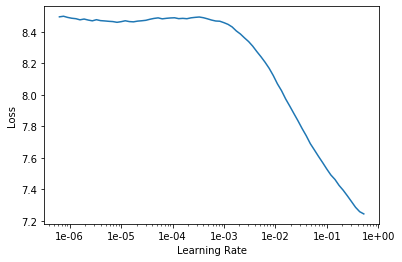

In [48]:
learn_lm.recorder.plot(skip_end=15)

In [50]:
learn_lm.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.103537,3.554966,0.371429,10:14


In [51]:
learn_lm.save('fit_head-JRC')

In [52]:
learn_lm.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))
learn_lm.save('fit_head-JRC')

epoch,train_loss,valid_loss,accuracy,time
0,5.178988,3.479254,0.400000,10:17


In [ ]:
learn_lm.load('fit_head-JRC')

In [54]:
learn=learn_lm
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


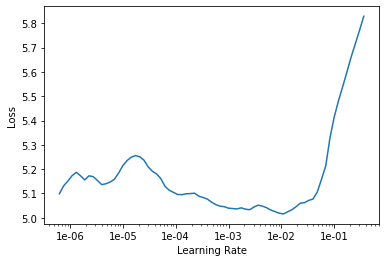

In [56]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [57]:
epochs = 7 # orig: 10
learn.fit_one_cycle(epochs, slice(1e-4, 1e-2) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.073738,3.027182,0.500000,11:44
1,4.257020,2.805593,0.557143,11:45
2,4.270291,2.601925,0.528571,11:44
3,3.743683,2.293327,0.614286,11:45
4,3.879797,2.395049,0.571429,11:45
5,3.729631,2.280197,0.600000,11:46
6,3.786686,2.232687,0.585714,11:45


In [58]:
learn.save('fine_tuned-JRC')

In [59]:
learn.load('fine_tuned-JRC');

In [60]:
# test lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The European Commission < legalact > < date > application < reference > ec treaty state aid enterprise production processing marketing product commission < legalact > application < reference > ec treaty state aid enterprise production processing marketing product commission regard treaty community
The European Commission < legalact > < date > application < reference > ec treaty state aid enterprise production processing marketing product commission regard treaty community subparagraph < reference > agreement area < reference > thereof regard council < legalact > < date
The European Commission request accordance < reference > council < legalact > < date > provision implementation council < legalact > community custom code implement rule measure community custom duty chapter < reference > council < legalact > < date > < legalact
The European Commission contribution proveniente kingdom share amount < date > < reference > a < legalact > community measure < reference > council < legalact > 

In [61]:
learn.save_encoder('fine_tuned_enc-JRC')

## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [7]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [8]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]
df.head(2)


,text,labels
0,commission community com proposal <legalact> p...,5498;3115;4511;4509;4515
1,parliament council <date> concern post worker ...,1424;557;1946;3005;5206;82


In [65]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [66]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'date', 'legalact', 'reference', 'state', 'commission', 'member', 'community', 'product', 'council']


In [9]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

In [10]:
data_clas.show_batch()
#data_clas.label_list


text,target
xxbos section commission content volume section commission title surplus title revenue person work institution community body revenue operation institution title contribution refund connection community agreement programme interest payment title borrow lending operation revenue title xx expenditure allocate policy area chapter xx expenditure allocate policy area title affair chapter expenditure affair policy area chapter union chapter affair chapter operation instrument title enterprise chapter expenditure enterprise policy area chapter policy innovation chapter,5158;933
xxbos commission < legalact > < date > list product council < legalact > commission community treaty community council < legalact > < date > establishment community survey production < reference > thereof whereas member state community survey production survey production product production survey list product permit production trade afford comparison community product nomenclature list product refer list member state order compare datum member state prodcom list measure accordance opinion,2720;3634;4258
xxbos council < legalact > < date > < legalact > community regime control export item technology council union regard treaty community < reference > thereof regard proposal commission < legalact > dualuse item control export community order member state community commitment list dualuse item technology < legalact > implement dualuse control arrangement missile technology control regime supplier group chemical weapon convention < reference > < legalact > conformity obligation,3156;4496;5461;5542
xxbos < date > < legalact > safety rule passenger commission community treaty community < legalact > < date > safety rule passenger ship < reference > point thereof convention safety life code resolution safety rule passenger vessel force date adoption < legalact > amendment sola convention code resolution enter force date adoption < legalact > force instrument annex < legalact > < legalact > accordance opinion committee < reference,2141;3641;4033;4511;4522;5234;5889
xxbos commission < legalact > < date > rule application council < legalact > regard support scheme title iv iva < legalact > use land production material content chapter scope provision chapter quality premium durum wheat chapter protein crop premium chapter payment rice chapter area payment chapter aid starch potato chapter dairy premium payment chapter aid energy crop section definition section contract section amendment termination contract section yield quantity deliver,1521;1839;2443;2734;3003;4630


In [11]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-JRC')


In [68]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of CrossEntropyLoss()
CrossEntropyLoss()


In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


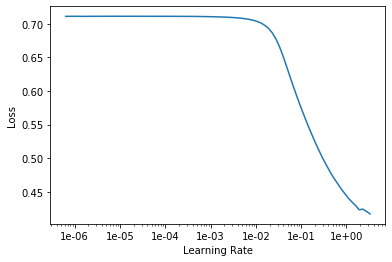

In [71]:
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(1, slice(1e-1,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.007484,0.006419,0.998603,0.827936,0.723389,0.184216,0.021517,0.981010,0.723755,0.183366,0.119988,0.995993,0.728864,0.179930,0.280607,0.997686,0.734117,0.175849,0.323610,0.998370,0.749747,0.167669,0.320163,0.998533,0.770684,0.158236,0.293344,0.998584,0.783096,0.152225,0.266450,0.998603,0.794771,0.144744,0.238704,04:38


In [73]:
learn.save('first')

In [ ]:
learn.load('first')

Why gradual unfreeze? Give example of Image detection.

In [75]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


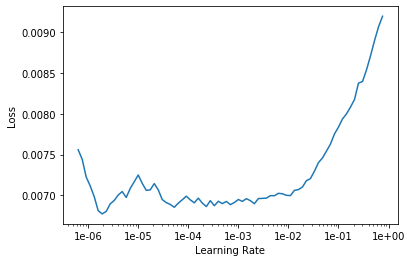

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(3, slice(3e-3/(2.6**4),3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006850,0.006241,0.998573,0.883217,0.707775,0.160767,0.033391,0.983689,0.709633,0.160442,0.151210,0.996126,0.713843,0.157841,0.307488,0.997640,0.721639,0.154956,0.334191,0.998312,0.731907,0.148741,0.318836,0.998482,0.747309,0.143464,0.282125,0.998551,0.756433,0.137060,0.250626,0.998573,0.771889,0.131372,0.221349,04:43
1,0.006256,0.005785,0.998635,0.874079,0.740088,0.211930,0.030059,0.982152,0.741788,0.211317,0.136821,0.996163,0.743905,0.207881,0.328566,0.997771,0.752025,0.204045,0.385599,0.998426,0.764664,0.196078,0.379300,0.998573,0.776056,0.188229,0.343077,0.998622,0.789095,0.180901,0.303697,0.998635,0.800137,0.172977,0.271474,04:47
2,0.005961,0.005605,0.998649,0.897600,0.744018,0.219144,0.035656,0.984684,0.744803,0.218400,0.156082,0.996420,0.747997,0.215176,0.347616,0.997856,0.755367,0.210352,0.399937,0.998451,0.766554,0.202933,0.391286,0.998603,0.778354,0.195274,0.357398,0.998641,0.791687,0.187145,0.314529,0.998649,0.803836,0.178889,0.280990,04:52


In [78]:
learn.save('second')

In [79]:
learn.load('second');

In [80]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


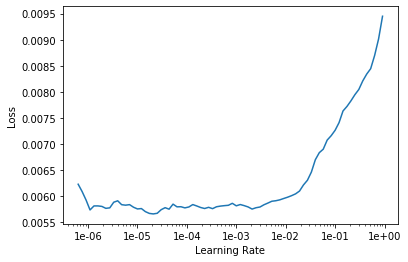

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(3, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006275,0.005541,0.998662,0.903119,0.710669,0.249151,0.052306,0.984688,0.711376,0.248300,0.185760,0.996319,0.714506,0.244796,0.360122,0.997755,0.720029,0.240641,0.404469,0.998396,0.735122,0.230406,0.397839,0.998568,0.752635,0.223365,0.370505,0.998633,0.765086,0.214917,0.337764,0.998662,0.781367,0.208387,0.312961,05:27
1,0.005721,0.005119,0.998728,0.908415,0.752981,0.284528,0.054305,0.984514,0.753022,0.282883,0.185262,0.996178,0.758129,0.278653,0.372514,0.997739,0.764421,0.274088,0.434557,0.998450,0.775330,0.265952,0.446869,0.998634,0.785653,0.256368,0.423506,0.998701,0.794814,0.247567,0.392097,0.998728,0.805048,0.240589,0.360927,05:33
2,0.005338,0.005005,0.998750,0.920416,0.759562,0.300858,0.072777,0.986140,0.759879,0.299305,0.208661,0.996426,0.765994,0.295231,0.395062,0.997836,0.772987,0.289940,0.455164,0.998492,0.783933,0.279735,0.469244,0.998671,0.796088,0.268249,0.445844,0.998737,0.804203,0.258119,0.416797,0.998750,0.817107,0.249732,0.381911,05:37


In [83]:
learn.save('third')

In [ ]:
learn.load('third')

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


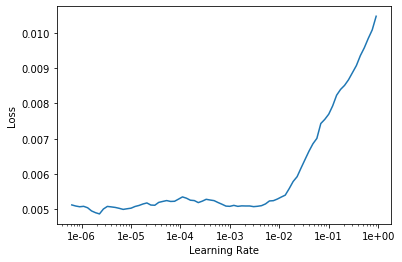

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.005132,0.004873,0.998755,0.917023,0.774446,0.293119,0.064712,0.985941,0.776005,0.292297,0.203141,0.996451,0.780029,0.287555,0.395974,0.997893,0.786254,0.283353,0.465195,0.998535,0.799399,0.274426,0.474866,0.998695,0.809232,0.264662,0.448738,0.998752,0.821101,0.255109,0.416239,0.998755,0.829835,0.246885,0.378297,06:19
1,0.005210,0.004931,0.998760,0.924253,0.747809,0.319818,0.073490,0.986321,0.748499,0.318788,0.208705,0.996320,0.754204,0.314237,0.391874,0.997791,0.761576,0.309166,0.458748,0.998477,0.772195,0.298207,0.477996,0.998667,0.784855,0.287871,0.459786,0.998742,0.800181,0.277793,0.434461,0.998760,0.816204,0.268268,0.400214,06:19
2,0.005184,0.004816,0.998769,0.921547,0.776662,0.304195,0.070519,0.986541,0.777971,0.303121,0.211136,0.996552,0.783471,0.298632,0.405401,0.997943,0.792150,0.293389,0.473414,0.998550,0.800963,0.284300,0.483367,0.998714,0.814943,0.274792,0.458171,0.998765,0.823833,0.265036,0.426335,0.998769,0.836498,0.256076,0.389513,06:26
3,0.005083,0.004749,0.998775,0.914680,0.767925,0.317241,0.069678,0.985467,0.768524,0.316229,0.208256,0.996328,0.773700,0.312195,0.403571,0.997844,0.782761,0.307181,0.470782,0.998528,0.793633,0.296404,0.489843,0.998710,0.807084,0.287046,0.467985,0.998768,0.818369,0.277360,0.437030,0.998775,0.833317,0.268681,0.399838,06:18
4,0.005005,0.004702,0.998780,0.928166,0.779699,0.312565,0.069113,0.987468,0.780717,0.311325,0.223820,0.996735,0.786338,0.307031,0.420779,0.998005,0.794520,0.301061,0.481372,0.998577,0.805496,0.290526,0.489564,0.998733,0.818370,0.279739,0.466714,0.998776,0.832821,0.270669,0.431607,0.998780,0.841937,0.260920,0.396141,06:17
5,0.005101,0.004599,0.998793,0.921488,0.752342,0.347542,0.066164,0.985704,0.752911,0.346149,0.213812,0.996220,0.759780,0.340214,0.409065,0.997757,0.766083,0.335692,0.479810,0.998503,0.776626,0.323604,0.508549,0.998699,0.788381,0.312230,0.491574,0.998774,0.801439,0.300182,0.464438,0.998793,0.814511,0.289395,0.428999,06:16
6,0.004948,0.004567,0.998804,0.929456,0.783200,0.331088,0.081349,0.987470,0.783885,0.330071,0.235692,0.996639,0.787139,0.324529,0.428223,0.997967,0.791226,0.318737,0.493163,0.998589,0.804591,0.308594,0.510873,0.998743,0.815494,0.298152,0.488332,0.998797,0.827245,0.288906,0.457335,0.998804,0.837717,0.278321,0.419555,06:17
7,0.004883,0.004554,0.998807,0.935859,0.765656,0.349915,0.076743,0.987956,0.766520,0.348732,0.234696,0.996604,0.771492,0.344295,0.424877,0.997922,0.777774,0.339223,0.489162,0.998556,0.792861,0.329656,0.511321,0.998742,0.805551,0.318490,0.497985,0.998798,0.817423,0.307086,0.469794,0.998807,0.826623,0.296409,0.433174,06:22
8,0.004977,0.004513,0.998808,0.935582,0.761300,0.359477,0.076018,0.988421,0.763187,0.358361,0.239943,0.996749,0.768644,0.354398,0.430354,0.997975,0.774740,0.347079,0.492278,0.998575,0.786191,0.335606,0.514255,0.998739,0.798061,0.325288,0.496255,0.998797,0.804162,0.315104,0.469024,0.998808,0.814640,0.305928,0.436349,06:21
9,0.004563,0.004442,0.998830,0.938647,0.786784,0.353328,0.080002,0.988571,0.788093,0.352252,0.245895,0.996762,0.791448,0.348107,0.440251,0.997998,0.795626,0.342954,0.505133,0.998589,0.805936,0.332513,0.522527,0.998761,0.814954,0.318956,0.507470,0.998814,0.825537,0.310222,0.477126,0.998830,0.836509,0.298575,0.443710,06:10


## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [16]:

# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [17]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report




In [31]:
thresh = 0.20

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.5506189587926064
P (micro) 0.5839227910322503
R (micro) 0.5209090909090909

F1 (macro) 0.14146711842644338
P (macro) 0.16035708762445922
R (macro)  0.14911105681650813


In [23]:
metrics = classification_report(y_true, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
        1000       0.00      0.00      0.00         5
        1005       0.00      0.00      0.00        42
        1008       0.00      0.00      0.00         1
        1010       0.00      0.00      0.00         0
        1011       0.00      0.00      0.00         0
        1012       0.00      0.00      0.00         0
        1015       0.00      0.00      0.00         6
        1018       0.67      0.36      0.47        11
        1019       0.00      0.00      0.00        23
        1021       0.00      0.00      0.00        17
        1025       0.00      0.00      0.00         5
        1026       0.33      1.00      0.50         1
        1030       0.00      0.00      0.00         0
        1031       1.00      0.50      0.67        10
        1034       0.00      0.00      0.00         2
        1035       0.00      0.00      0.00         8
        1036       0.00    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
